In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [31]:
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


EXAMINE DATA

In [32]:
# Check class balance
df_original['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

SELECT AN EVALUATION METRIC

In [33]:
# Calculate average balance of customer who churned
avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726068

FEATURE ENGINEERING
feature selection

In [34]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], 
                            axis=1)

In [35]:
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


future transformation


In [36]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)

churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


SPLIT THE DATA

In [37]:
# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, stratify=y, 
                                                    random_state=42)

BASELINE MODEL

In [38]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [39]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.790
Precision: 0.486
Recall: 0.503
F1 Score: 0.494


Analysis of baseline model

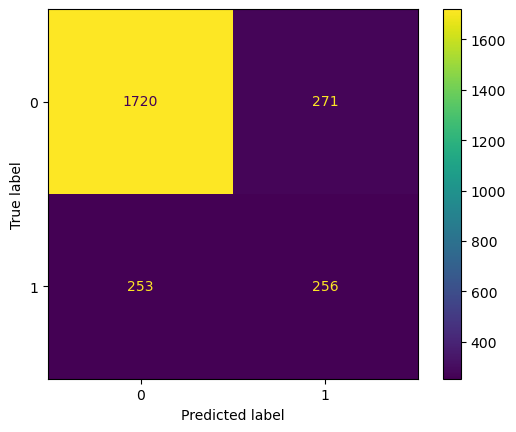

In [40]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

Plotting the tree

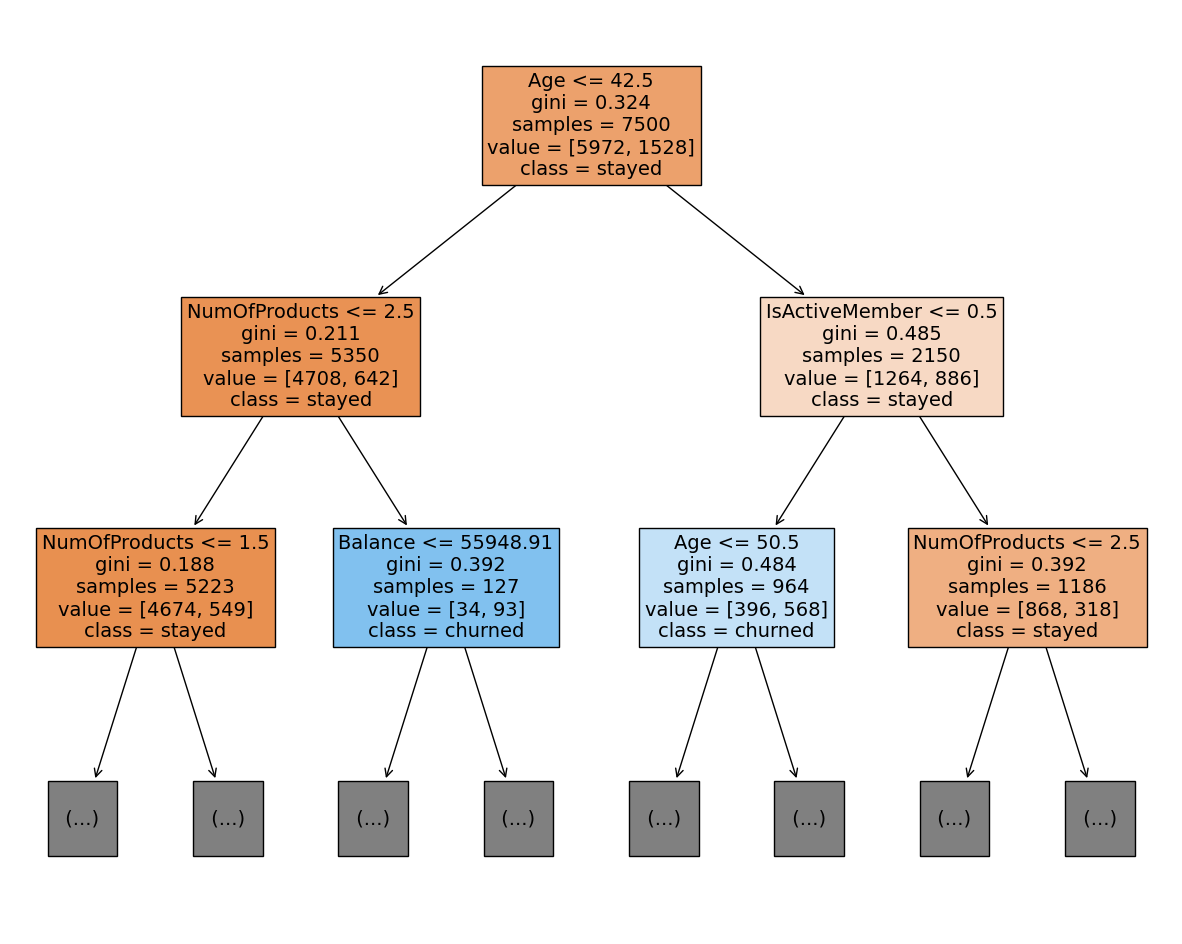

In [41]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

A note on modeling workflow and model selection

Import statements

In [42]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

Cross - validated hyperparameter tuning

In [43]:
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [44]:
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [45]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [46]:
# Instantiate the GridSearch
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
clf.fit(X_train, y_train)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'top_k_accuracy', 'neg_mean_absolute_error', 'f1_macro', 'neg_mean_absolute_percentage_error', 'recall_weighted', 'r2', 'neg_median_absolute_error', 'matthews_corrcoef', 'jaccard_weighted', 'roc_auc_ovr', 'f1_micro', 'completeness_score', 'accuracy', 'f1_weighted', 'jaccard_micro', 'average_precision', 'jaccard_samples', 'rand_score', 'roc_auc_ovr_weighted', 'neg_root_mean_squared_error', 'roc_auc_ovo', 'precision_micro', 'max_error', 'recall_macro', 'recall_samples', 'adjusted_rand_score', 'v_measure_score', 'balanced_accuracy', 'explained_variance', 'normalized_mutual_info_score', 'roc_auc', 'f1_samples', 'fowlkes_mallows_score', 'neg_negative_likelihood_ratio', 'mutual_info_score', 'f1', 'precision_macro', 'jaccard', 'precision_weighted', 'neg_mean_poisson_deviance', 'positive_likelihood_ratio', 'adjusted_mutual_info_score', 'neg_mean_squared_log_error', 'neg_mean_gamma_deviance', 'neg_mean_squared_error', 'recall_micro', 'neg_brier_score', 'precision', 'precision_samples', 'neg_root_mean_squared_log_error', 'recall', 'jaccard_macro', 'homogeneity_score', 'neg_log_loss', 'roc_auc_ovo_weighted'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got {'f1', 'precision', 'recall', 'accuracy'} instead.

In [47]:

# Examine the best model from GridSearch
clf.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
Cross-validated hyperparameter tuning